In [1]:
import os
import requests
import pandas as pd
import time 
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from datetime import datetime

# Extract data from CSV

## Function

In [2]:
def get_data(path, file_names):
    tables=[]
    for file_name in file_names:
        table = pd.read_csv(f'../{path}/{file_name}.csv')
        table['type']=f'{file_name}'
        tables.append(table)
    return pd.concat(tables)

path='data/raw_data'
file_names = ['trawlers', 'drifting_longlines', 'fixed_gear', 'pole_and_line', 'purse_seines', 'trollers', 'unknown']

df = get_data(path, file_names)

df.head()

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,source,type
0,1.252340e+12,1.325376e+09,0.0,0.0,0.0,153.0,52.458649,4.581200,-1.0,gfw,trawlers
1,1.252340e+12,1.325378e+09,0.0,0.0,0.0,153.0,52.458668,4.581167,-1.0,gfw,trawlers
2,1.252340e+12,1.325379e+09,0.0,0.0,0.0,153.0,52.458633,4.581183,-1.0,gfw,trawlers
3,1.252340e+12,1.325380e+09,0.0,0.0,0.0,153.0,52.458649,4.581234,-1.0,gfw,trawlers
4,1.252340e+12,1.325381e+09,0.0,0.0,0.0,153.0,52.458649,4.581183,-1.0,gfw,trawlers


In [3]:
df['mmsi'].nunique()

354

# Remove unknown (-1 in is_fishing column)

In [4]:
df = df.loc[df['is_fishing'] > -1]

In [5]:
df['is_fishing'].value_counts()

is_fishing
0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: count, dtype: int64

# OHE 'type'

In [6]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output =False)

# Fit encoder
ohe.fit(df[['type']])

# Transform the current "Alley" column
df[ohe.get_feature_names_out()] = ohe.transform(df[['type']])

# Drop the column "Alley" which has been encoded
df.drop(columns = ["type", "source"], inplace = True)

In [7]:
df.head(3)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,1.420089e+09,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60648,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
df_fishing = df
df_fishing['is_fishing'].value_counts()

is_fishing
0.000000    295979
1.000000    247498
0.666667      4806
0.333333      4096
0.750000       752
0.250000       670
0.800000        33
0.166667        12
0.400000         9
Name: count, dtype: int64

In [9]:
df_fishing.loc[:, ('is_fishing')] = round(df_fishing.loc[:, ('is_fishing')])

In [10]:
df_fishing['is_fishing'].value_counts()

is_fishing
0.0    300766
1.0    253089
Name: count, dtype: int64

In [11]:
df_fishing.head(3)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,1.420089e+09,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60648,1.252340e+12,1.420090e+09,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
df_fishing['timestamp'] = pd.to_datetime(df_fishing['timestamp'], unit='s')

In [13]:
df_fishing.head(2)

,mmsi,timestamp,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [14]:
df_fishing.rename(columns={"timestamp": "date"}, inplace=True)
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
df_fishing['year'] = df_fishing['date'].dt.year
# 12 columns for month
df_fishing['month'] = df_fishing['date'].dt.month
#df_fishing['day'] = df_fishing['date'].dt.day
# 7 columns for days
df_fishing['day_of_week'] = df_fishing['date'].dt.day_of_week
#df_fishing['day_of_year'] = df_fishing['date'].dt.day_of_year

In [16]:
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3


In [17]:
import pytz
from datetime import datetime

def get_utc_offset_from_longitude(longitude):
    timezone = pytz.timezone(pytz.country_timezones("US")[0])  # You can replace "US" with the appropriate country code
    now = datetime.now(timezone)
    utc_offset = now.utcoffset().total_seconds() / 3600
    return utc_offset

df_fishing['utc_offset'] = df_fishing['lon'].apply(get_utc_offset_from_longitude)

In [18]:
df_fishing.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,type_fixed_gear,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,utc_offset
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0


In [19]:
df_fishing['year'].value_counts()

year
2015    307684
2014    192463
2013     38785
2012     10665
2016      4258
Name: count, dtype: int64

# Export to CSV for quick access

In [20]:
output_folder = '../data/preprocessed'
output_file = 'preproc.csv'

# Construct the full path
output_path = f'{output_folder}/{output_file}'

# Save the DataFrame to the specified path
df_fishing.to_csv(output_path, index=False)

# Map data on world map with geopandas

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [22]:
geometry = [Point(xy) for xy in zip(df_fishing['lon'], df_fishing['lat'])]

In [23]:
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(df_fishing, #specify our data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created
geo_df.head()

/Users/grace/.pyenv/versions/3.10.6/envs/fishing_classification/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,utc_offset,geometry
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58132 52.45872)
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58132 52.45873)
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58127 52.45870)
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58123 52.45870)
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58118 52.45868)


In [24]:
boat = geo_df._get_value(60649, 'mmsi')
boat

1252339803566.0

In [25]:
one_boat = geo_df.loc[geo_df['mmsi']== boat]

<Axes: >

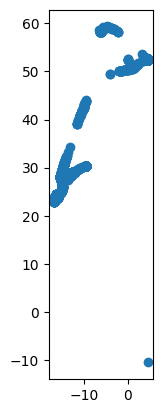

In [26]:
one_boat.plot()

/var/folders/jp/3hlxbh4x1mb0k2qwf5fmzyp80000gp/T/ipykernel_29452/3434163748.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/var/folders/jp/3hlxbh4x1mb0k2qwf5fmzyp80000gp/T/ipykernel_29452/3434163748.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, cmap='autumn')


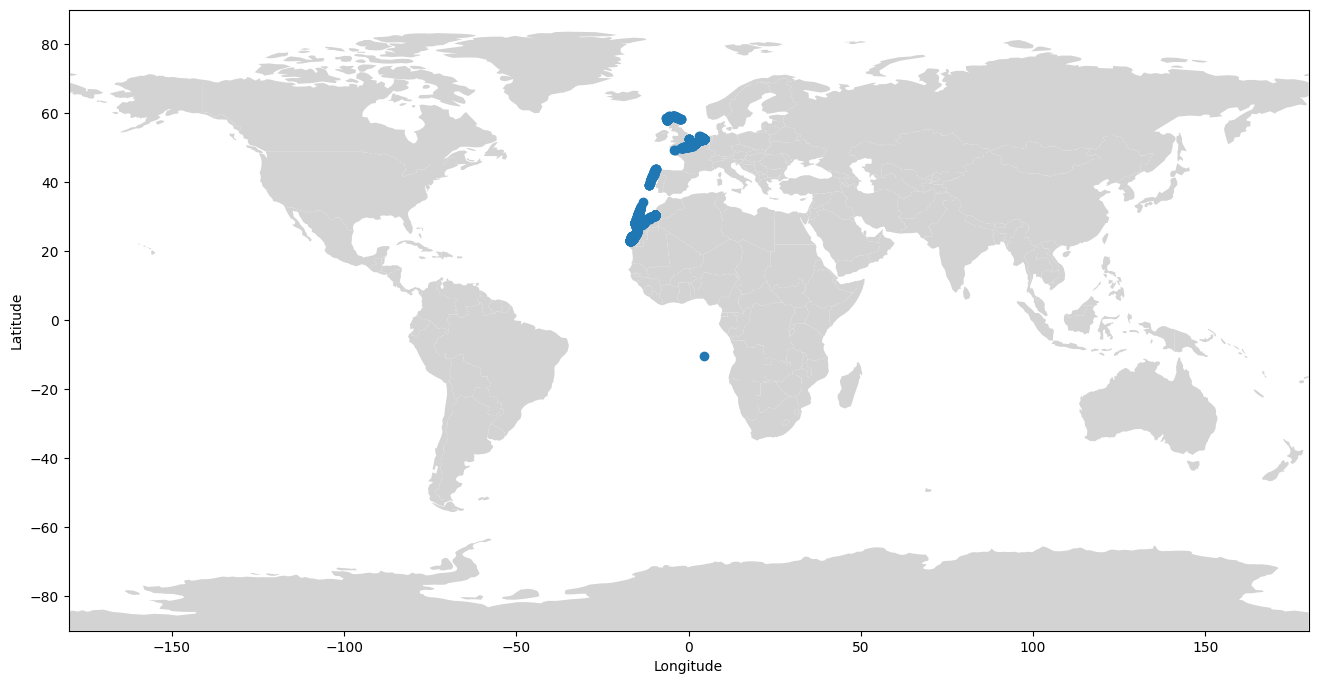

In [27]:
# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = one_boat['lon']
y = one_boat['lat']
plt.scatter(x, y, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

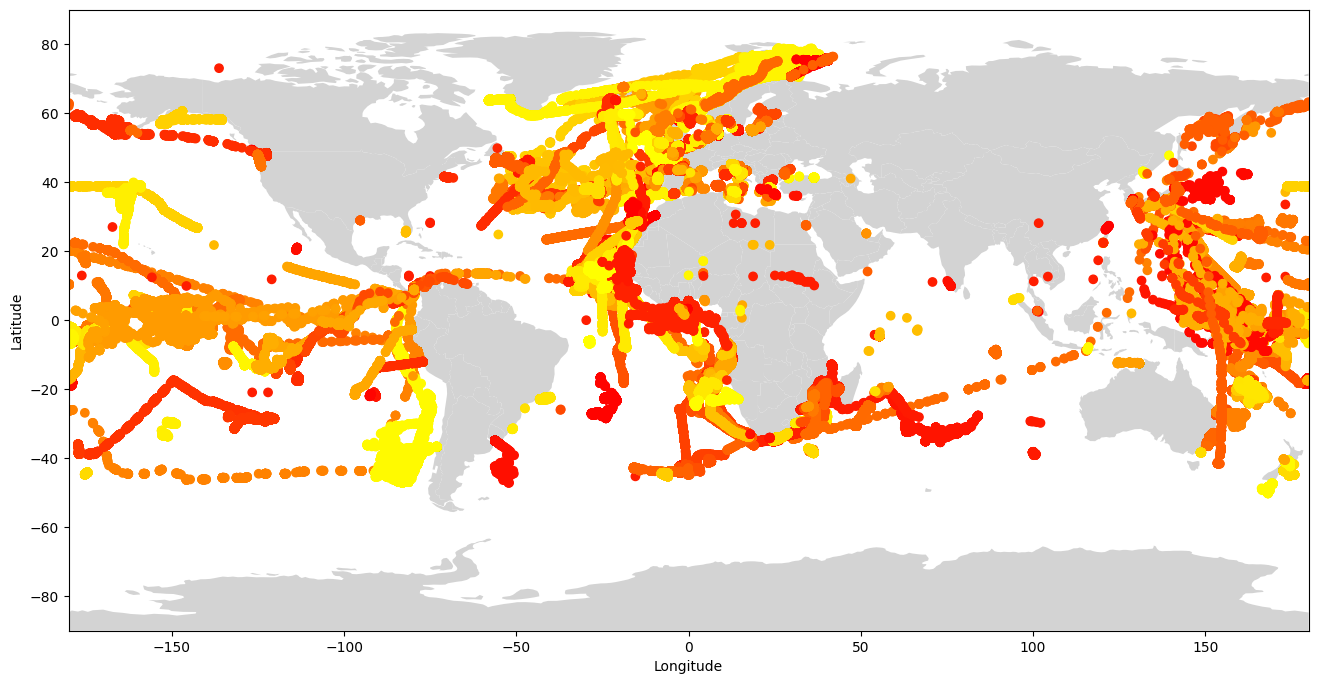

In [28]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting Longitudes and Latitudes of one boat
x = geo_df['lon']
y = geo_df['lat']
boats = geo_df['mmsi']
plt.scatter(x, y, c=boats, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [29]:
geo_df['mmsi'].value_counts()

mmsi
2.690503e+14    37423
2.748501e+14    14896
6.260384e+13    11335
6.960986e+13    10592
1.304817e+14     9832
                ...  
2.472845e+14        2
2.473046e+14        2
1.686984e+14        1
9.400902e+13        1
9.924005e+12        1
Name: count, Length: 330, dtype: int64

In [30]:
geo_df['mmsi'].nunique()

330

In [31]:
# Calculate the value counts of 'mmsi'
mmsi_counts = geo_df['mmsi'].value_counts()

# Create a boolean mask for filtering mmsi values with counts less than or equal to 10
mask = mmsi_counts < 20

# Get the mmsi values that meet the condition
selected_mmsi = mmsi_counts[mask].index

# Use the isin() method to filter the DataFrame based on selected_mmsi
filtered_geo_df = geo_df[geo_df['mmsi'].isin(selected_mmsi)]

In [32]:
filtered_geo_df['mmsi'].value_counts()

mmsi
9.764633e+13    18
8.681774e+13    18
2.601425e+14    18
1.680158e+14    18
4.408144e+13    18
1.055795e+14    18
2.419961e+14    16
2.002852e+14    16
1.742621e+14    16
5.020143e+12    15
2.091231e+14    15
1.182811e+14    15
1.480448e+14    14
8.947022e+13    13
1.652170e+14    13
2.218362e+13    13
1.246766e+14    12
2.162561e+13    12
1.314049e+14    12
1.914804e+13    12
3.621263e+13    11
1.060799e+14    11
2.259795e+14    10
1.838128e+14    10
1.653486e+14    10
8.079808e+13     9
5.492675e+13     9
2.746770e+14     9
1.039123e+14     8
2.101065e+13     8
1.833071e+14     8
1.583170e+14     7
1.414009e+14     6
4.095621e+13     5
1.934990e+14     5
4.083411e+13     5
1.609231e+14     5
1.397611e+14     4
2.596001e+14     4
1.833153e+14     4
1.826980e+13     3
6.182047e+13     3
8.126396e+13     2
1.319931e+14     2
7.433217e+13     2
1.335548e+14     2
6.455101e+13     2
2.472845e+14     2
2.473046e+14     2
1.100141e+14     2
9.400902e+13     1
9.924005e+12     1
1.68698

In [33]:
filtered_geo_df['mmsi'].nunique()

53

In [34]:
# Calculate the value counts of 'mmsi'
mmsi_counts = geo_df['mmsi'].value_counts()

# Create a boolean mask for filtering mmsi values with counts less than or equal to 10
mask = mmsi_counts > 50

# Get the mmsi values that meet the condition
selected_mmsi = mmsi_counts[mask].index

# Use the isin() method to filter the DataFrame based on selected_mmsi
filtered_geo_df = geo_df[geo_df['mmsi'].isin(selected_mmsi)]

In [35]:
filtered_geo_df['mmsi'].nunique()

258

In [36]:
filtered_geo_df.shape

(552752, 21)

In [37]:
filtered_geo_df.head()

,mmsi,date,distance_from_shore,distance_from_port,speed,course,lat,lon,is_fishing,type_drifting_longlines,...,type_pole_and_line,type_purse_seines,type_trawlers,type_trollers,type_unknown,year,month,day_of_week,utc_offset,geometry
60646,1.252340e+12,2015-01-01 05:08:23,0.0,0.0,0.0,128.0,52.458717,4.581316,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58132 52.45872)
60647,1.252340e+12,2015-01-01 05:20:34,0.0,0.0,0.0,128.0,52.458733,4.581316,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58132 52.45873)
60648,1.252340e+12,2015-01-01 05:32:53,0.0,0.0,0.0,128.0,52.458698,4.581267,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58127 52.45870)
60649,1.252340e+12,2015-01-01 05:45:23,0.0,0.0,0.0,128.0,52.458698,4.581234,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58123 52.45870)
60650,1.252340e+12,2015-01-01 05:57:24,0.0,0.0,0.0,128.0,52.458683,4.581183,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2015,1,3,-4.0,POINT (4.58118 52.45868)
